In [9]:
from colour_demosaicing import demosaicing_CFA_Bayer_bilinear,demosaicing_CFA_Bayer_Malvar2004, demosaicing_CFA_Bayer_Menon2007

from torchvision import transforms, utils

import importlib

import classifier
importlib.reload(classifier)

from classifier import Model

import utils.dataset 
importlib.reload(utils.dataset )
from utils.dataset import * 

## Load the data

Before you load the data, you need to run Save_split_raw_drone_images.ipynb to download the raw data and store the subimages  as .npy array.

In [12]:
train_loc = './data/DroneImages/train663_random_state_72 11859.csv'
test_loc = './data/DroneImages/test663_random_state_72 11859.csv'

mean = torch.tensor([8742.9814, 8742.9814, 8742.9814])
std = torch.tensor([5097.3960, 5097.3960, 5097.3960])

Calculate mean and std:

In [14]:
'''
trainset = Raw_Dataset(csv_file=train_loc,
                             root_dir = './data/DroneImages/sub_input_numpy',
                              class_name='car',
                                    transform = transforms.Compose([ToTensor(stacked=True)]))

print(len(trainset))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1062, shuffle=True, num_workers=4)

dataiter = iter(trainloader)
images,labels = dataiter.next()
torch.mean(images,axis=(0,2,3)),torch.std(images,axis=(0,2,3))
'''

1062


(tensor([8742.9873, 8742.9873, 8742.9873]),
 tensor([5097.3887, 5097.3887, 5097.3887]))

Check mean and std:

In [16]:
'''
trainset = Raw_Dataset(csv_file=train_loc,
                             root_dir = './data/DroneImages/sub_input_numpy',
                              class_name='car',
                                    transform = transforms.Compose([ToTensor(stacked=True),transforms.Normalize(mean,std)]))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=1062, shuffle=True, num_workers=4)

dataiter = iter(trainloader)
images,labels = dataiter.next()
torch.mean(images,axis=(0,2,3)),torch.std(images,axis=(0,2,3))
'''

(tensor([5.1483e-07, 5.1483e-07, 5.1483e-07]),
 tensor([1.0000, 1.0000, 1.0000]))

In [17]:
trainset = Raw_Dataset(csv_file=train_loc,
                             root_dir = './data/DroneImages/sub_input_numpy',
                              class_name='car',
                                    transform = transforms.Compose([ToTensor(stacked=True),transforms.Normalize(mean,std)]))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=4)

testset = Raw_Dataset(csv_file=test_loc,
                             root_dir = './data/DroneImages/sub_input_numpy',
                              class_name='car',
                                    transform = transforms.Compose([ToTensor(stacked=True),transforms.Normalize(mean,std)]))

testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True, num_workers=4)

classes = ('no car', 'car')

In [18]:
print('Proportion of class car in trainset:',sum([trainset[i][1] for i in range(len(trainset))])/len(trainset))
print('Proportion of class car in testset:',sum([testset[i][1] for i in range(len(testset))])/len(testset))

Proportion of class car in trainset: 0.5
Proportion of class car in testset: 0.5


## Train a ResNetX

In [13]:
import torchvision.models as models

resnet18 = models.resnet18(pretrained=True)
#resnet18.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet18.fc = torch.nn.Linear(in_features=512, out_features=2, bias=True)

In [15]:
model = Model(resnet18,trainloader,testloader)

[0.5122180451127819]
[0.5151515151515151]


/home/nobis/anaconda3/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729062494/work/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


epoch 1 minimbatch 1 --  loss: 1.92827165e-02 -- learning rate: 1.00000000e-04
epoch 1 minimbatch 41 --  loss: 6.63524918e-01 -- learning rate: 1.00000000e-04
epoch 1 minimbatch 81 --  loss: 6.63610847e-01 -- learning rate: 1.00000000e-04
epoch 1 minimbatch 121 --  loss: 6.17951922e-01 -- learning rate: 1.00000000e-04
epoch 1 minimbatch 161 --  loss: 5.66593774e-01 -- learning rate: 1.00000000e-04
epoch 1 minimbatch 201 --  loss: 5.56632092e-01 -- learning rate: 1.00000000e-04
epoch 1 minimbatch 241 --  loss: 5.21606726e-01 -- learning rate: 1.00000000e-04
EPOCH 1 DONE --  loss: 5.96729130e-01
[0.5122180451127819, 0.7509398496240601]
[0.5151515151515151, 0.7272727272727273]
epoch 2 minimbatch 1 --  loss: 1.40977889e-02 -- learning rate: 1.00000000e-04
epoch 2 minimbatch 41 --  loss: 5.02888141e-01 -- learning rate: 1.00000000e-04
epoch 2 minimbatch 81 --  loss: 5.42340831e-01 -- learning rate: 1.00000000e-04
epoch 2 minimbatch 121 --  loss: 5.63202376e-01 -- learning rate: 1.00000000e-

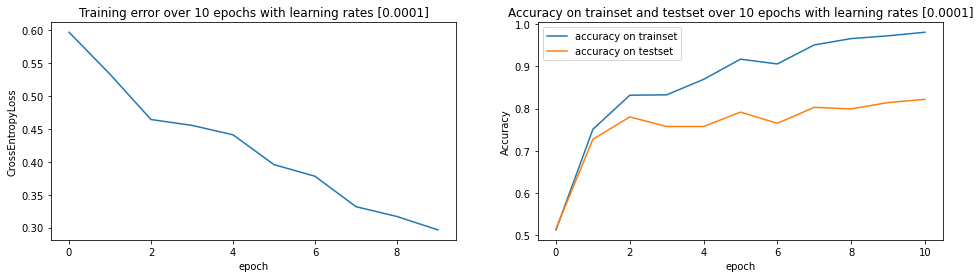

Finished Training


In [16]:
model.train(epochs=10,lrs=[1e-4],plot=True)

In [21]:
path = './trained/DroneImages/ResNet18/pre_trained/pre_trained_raw_stacked_random_state_72 11859.pth'
torch.save(model.net.state_dict(),path)

In [9]:
import torchvision.models as models

path = './trained/DroneImages/ResNet18/pre_trained/pre_trained_raw_visible_stacked_random_state_72 11859.pth'
resnet18 = models.resnet18(pretrained=False)
resnet18.fc = torch.nn.Linear(in_features=512, out_features=2, bias=True)
model = Model(resnet18,trainloader,testloader)
model.net.load_state_dict(torch.load(path))

<All keys matched successfully>

In [23]:
B_1 = Visible_Raw_Dataset(csv_file=test_loc,
                             root_dir = './data/DroneImages/sub_input_numpy',
                              class_name='car',
                                    transform = transforms.Compose([Demosaicing(),transforms.Normalize(mean,std)]))

B_1_loader = torch.utils.data.DataLoader(B_1, batch_size=4, shuffle=True, num_workers=4)

In [24]:
model.predict(testloader)

0.821969696969697

In [25]:
model.predict(B_1_loader)

0.6704545454545454

In [26]:
B_2 = Visible_Raw_Dataset(csv_file=test_loc,
                             root_dir = './data/DroneImages/sub_input_numpy',
                              class_name='car',
                                    transform = transforms.Compose([Demosaicing(demosaic = demosaicing_CFA_Bayer_Malvar2004),transforms.Normalize(mean,std)]))

B_2_loader = torch.utils.data.DataLoader(B_2, batch_size=4, shuffle=True, num_workers=4)

In [27]:
model.predict(B_2_loader)

0.6742424242424242

In [28]:
B_3 = Visible_Raw_Dataset(csv_file=test_loc,
                             root_dir = './data/DroneImages/sub_input_numpy',
                              class_name='car',
                                    transform = transforms.Compose([Demosaicing(demosaic = demosaicing_CFA_Bayer_Menon2007),transforms.Normalize(mean,std)]))

B_3_loader = torch.utils.data.DataLoader(B_3, batch_size=4, shuffle=True, num_workers=4)

In [29]:
model.predict(B_3_loader)

0.6818181818181818